# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = ASIA_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
neer = read_prices("../../Dymon/Code Data/NEER.csv")

In [5]:
neer.columns = [x[0] for x in neer.columns]

In [6]:
asia_neer = neer[[("JBDN"+x+" Index") for x in ["SGD", "THB", "TWD", "KRW", "PHP", "INR", "IDR", "CNY"]]]
asia_neer.columns = ["USD"+x for x in ["SGD", "THB", "TWD", "KRW", "PHP", "INR", "IDR", "CNH"]]
asia_neer_cleaned = asia_neer.pipe(fill_date, True).pipe(omit_trailing_na)
asia_neer_cleaned.loc[:,"USDMYR"] = pd.Series(np.nan)

# Data integrity

In [7]:
asia_neer_cleaned.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5665 entries, 2000-01-03 to 2021-09-17
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDSGD  5665 non-null   float64
 1   USDTHB  5665 non-null   float64
 2   USDTWD  5665 non-null   float64
 3   USDKRW  5665 non-null   float64
 4   USDPHP  5665 non-null   float64
 5   USDINR  5665 non-null   float64
 6   USDIDR  5665 non-null   float64
 7   USDCNH  5665 non-null   float64
 8   USDMYR  0 non-null      float64
dtypes: float64(9)
memory usage: 442.6 KB


<AxesSubplot:>

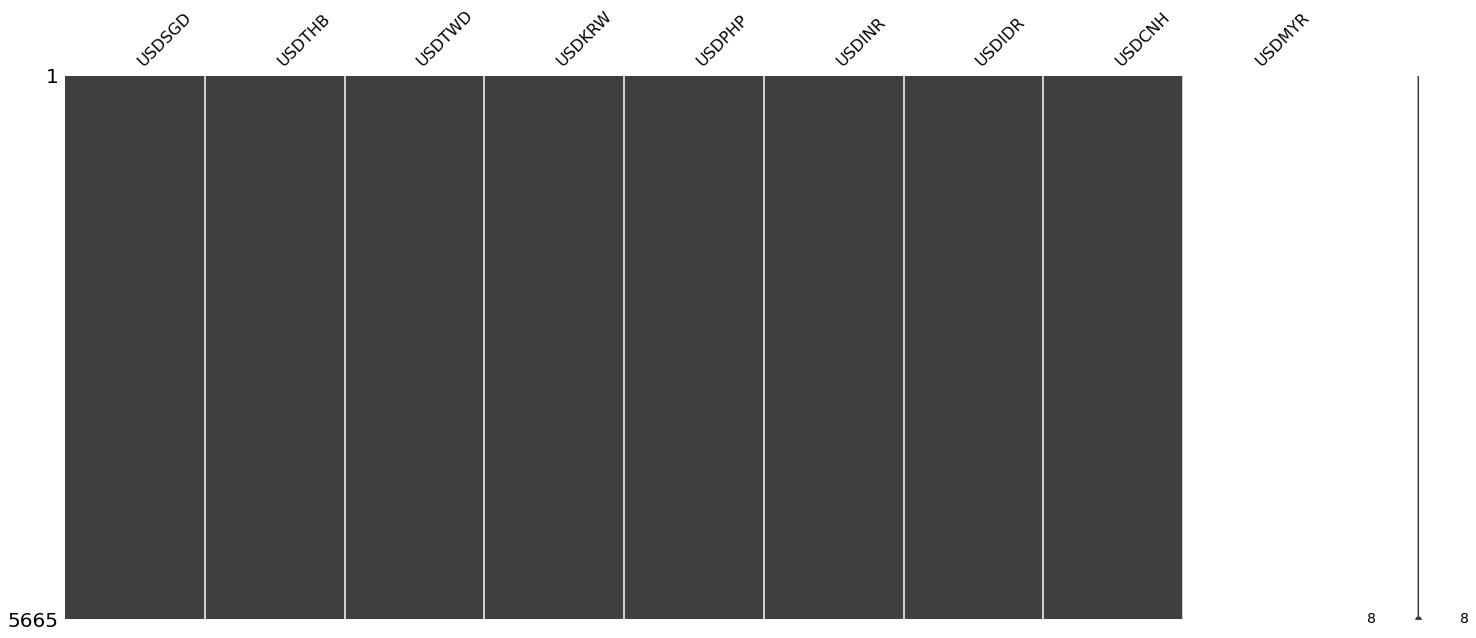

In [8]:
msmx(asia_neer_cleaned.pipe(fill_date))

# Signal 

In [9]:
def band_filter(series):
  return series.applymap(lambda x: -x if abs(x) > 1.5 else 0)

def hold_until_flip(series):
  ser = pd.DataFrame(series)
  ser.columns = ["ccy"]
  ser["shift"] = ser.shift(1)
  ser["sign_change"] = ser.apply(lambda row: 1 if abs(row["ccy"]) > 1.5 else 0, axis=1)
  ser["sign_change"] = ser.apply(lambda row: 1 if row["sign_change"] == 1 else np.nan if pd.isna(row["ccy"]) else 4 if np.sign(row["ccy"]) != np.sign(row["shift"]) else 0 , axis=1)
  ser["signal"] = ser[["ccy"]].pipe(band_filter)
  ser['sign_forward']=ser['sign_change'].replace(0, np.NaN).ffill()
  ser['sign_shift'] = ser['sign_forward'].diff().replace(0, np.NaN)
  ser["signal"] = ser.apply(lambda row: np.nan if pd.isna(row["sign_shift"]) else row["signal"], axis=1).ffill()
  
  return ser["signal"]

In [10]:
sig = asia_neer_cleaned.ffill().pct_change().pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1

In [11]:
sig = sig.pipe(demean_xs).pipe(top_bottom_xs)
sig[abs(sig) < 0.25] = 0
sig = CAP(sig, 2.5)

# Backtest Daily Rebal

In [12]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [13]:
get_summary(daily_bt)

Returns   : 0.006086568594397947
Vol       : 0.11291742279439297
SR        : 0.05390282955253724
Max DD    : -36.0

C Returns : -0.00032405455118109214
C SR      : -0.0027815109881638256
C Max DD  : -32.91

Hit rate  : 0.504
W | N | L : 0.33 | 0.35 | 0.32
W/L Ratio : 1.01


In [14]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

C:\Users\vin_s\National University of Singapore\FSP Dymon AY21 22 Term 1 - Documents\Codebase\02_Value\..\genesis.py:611: RuntimeWarning: invalid value encountered in double_scalars
  return (ret - rf).mean() * np.sqrt(obs_per_year) / ret.std()
C:\Users\vin_s\National University of Singapore\FSP Dymon AY21 22 Term 1 - Documents\Codebase\02_Value\..\genesis.py:615: RuntimeWarning: invalid value encountered in double_scalars
  return (dollar_ret - rf).mean() * np.sqrt(obs_per_year) / dollar_ret.std()


,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH
annualized_return,0.861618,-0.486049,0.825308,-0.795671,0.595165,-0.170718,0.786424,0.0,-1.129974
sharpe,0.255628,-0.105641,0.248687,-0.209179,0.170075,-0.034293,0.220601,NaN,-0.513801
dollar_sharpe,0.224878,-0.124836,0.234223,-0.236981,0.145743,-0.05923,0.215693,NaN,-0.528554
trade_sharpe,-0.288405,-0.451058,0.111719,-0.539857,0.30531,-0.498684,0.228713,NaN,-0.200519
long_sharpe,0.930714,-0.269,-1.521563,0.519946,0.143572,-1.419017,0.139809,NaN,0.343299
short_sharpe,-0.738686,-1.01181,1.084782,-1.38324,0.707119,0.0588,0.601393,NaN,-4.033074
sortino,0.074604,-0.027414,0.067156,-0.043781,0.038239,-0.006745,0.038807,NaN,-0.100152
max_drawdown,-16.116528,-24.153068,-13.228104,-20.732695,-9.598445,-23.072602,-15.268904,0.0,-21.768781
max_drawdown_start,2011-09-07,2006-12-21,2011-02-14,2004-02-25,2015-06-05,2004-03-25,2005-09-14,2016-12-30,2011-09-26
max_drawdown_end,2015-04-03,2016-09-09,2015-01-27,2011-09-22,2016-12-30,2004-05-06,2011-09-28,2016-12-30,2016-11-11


C:\Users\vin_s\National University of Singapore\FSP Dymon AY21 22 Term 1 - Documents\Codebase\02_Value\..\genesis.py:673: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  returns = returns.drop([i],1)


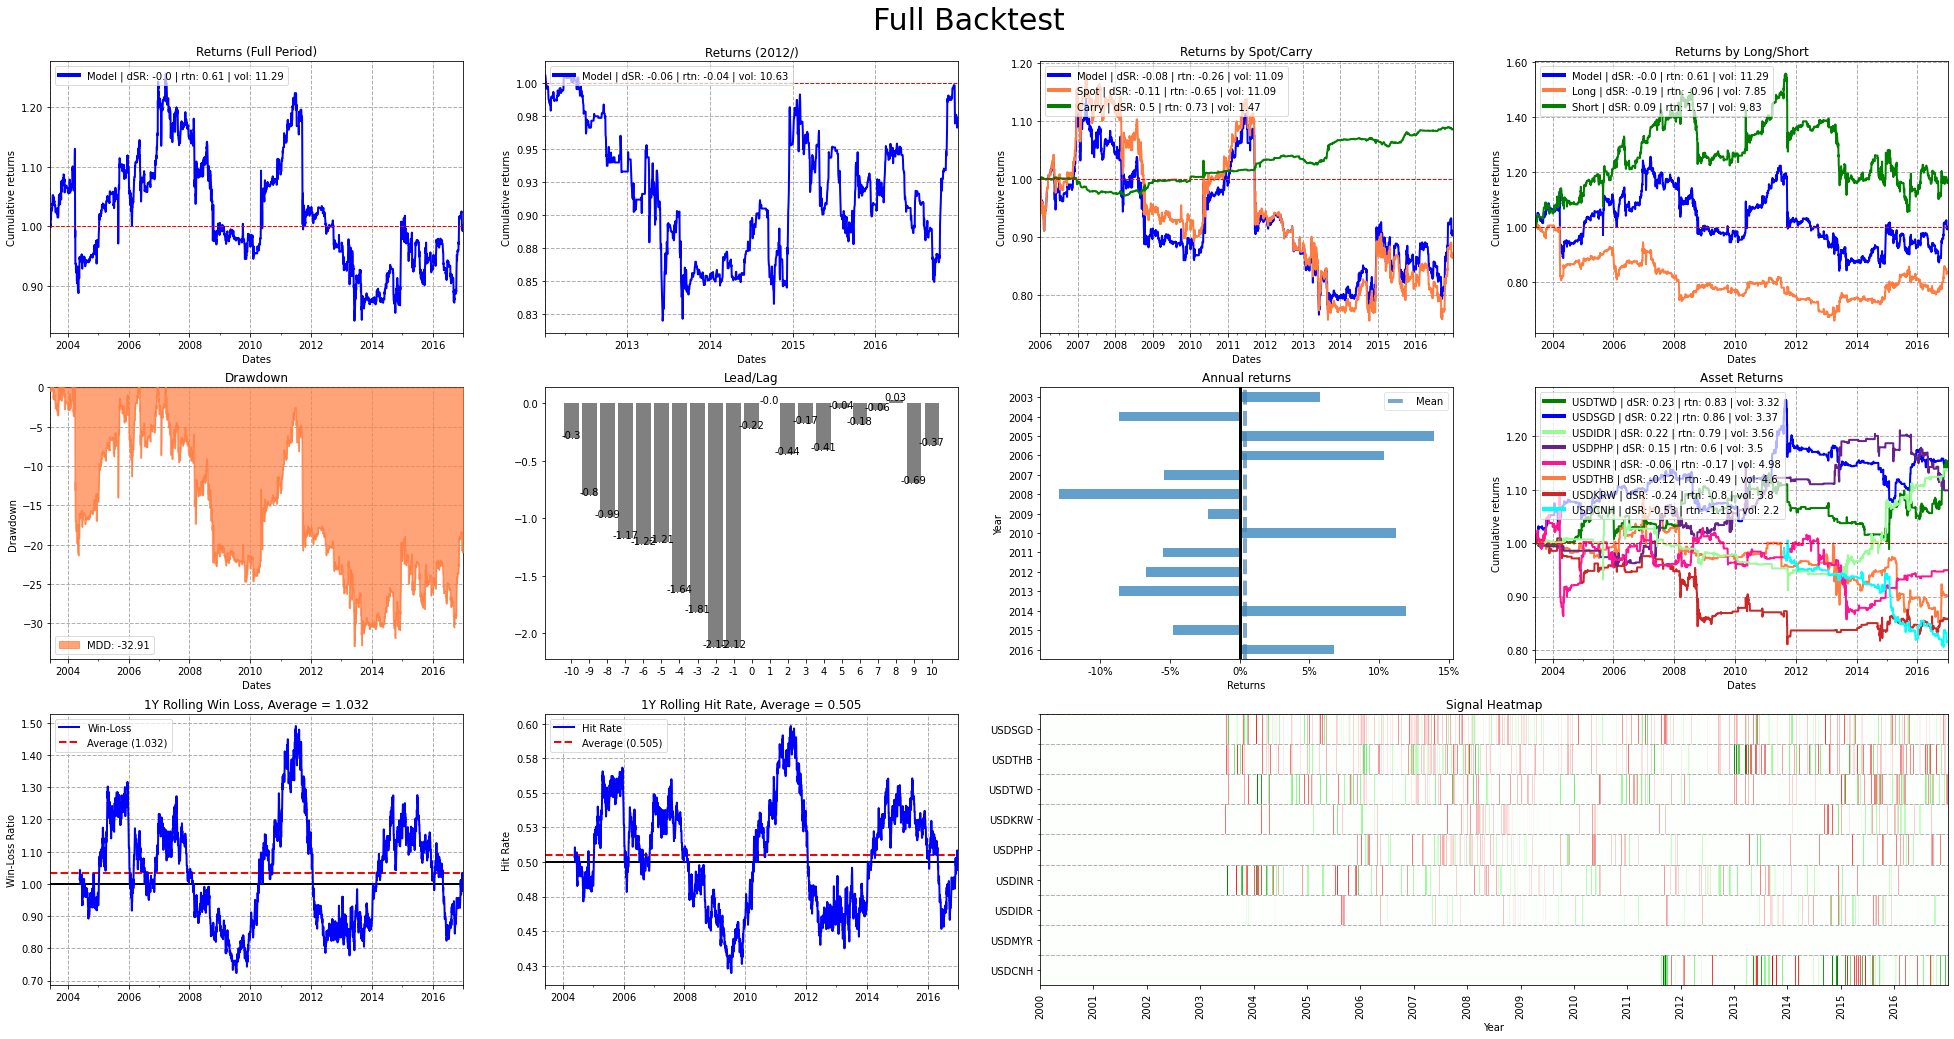

In [15]:
plot_bt(daily_bt)

# Backtest Weekly Rebal

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

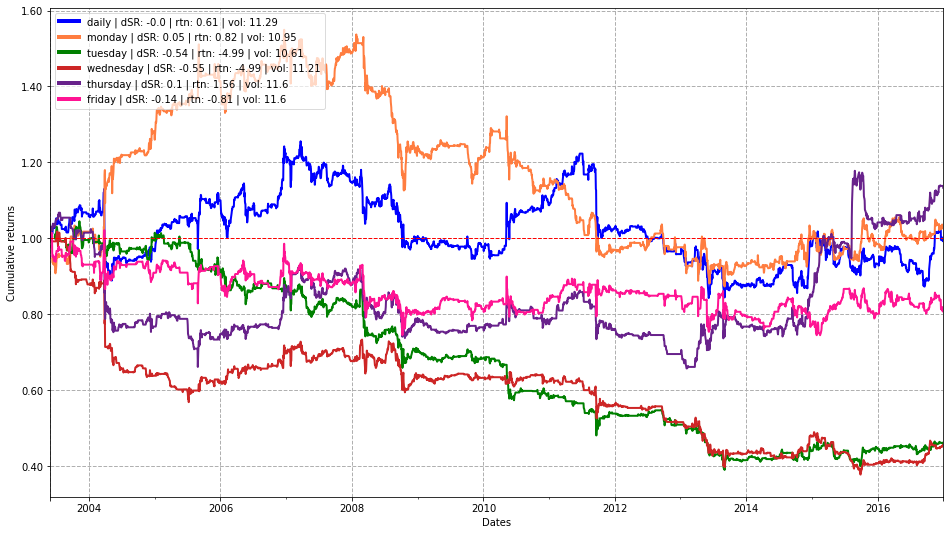

In [16]:
bts = [Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":t}) for t in ["monday","tuesday", "wednesday",
                                                                 "thursday", "friday"]]
for bt in bts:
  bt.run()
  
gen_plot_rtn(pd.concat([x.model_rtn.rename(x.rebalance_period) for x in [daily_bt]+bts], axis=1))

In [17]:
pickle.dump(daily_bt, open("../BT/jpm_neer_asia_daily.p", "wb"))
daily_bt = pickle.load(open("../BT/jpm_neer_asia_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/carry_unwinding_all_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/carry_unwinding_all_weekly.p", "rb"))

# Regime Plot

# Sensitivity Analysis